In [1]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *

# To activate logging
setup_logging()

## Cosmology

In [2]:
z = 1.175

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

k=np.logspace(-5, 3, 100000)

## Gaussian mock to compare to model

In [3]:
output_dir = '/feynman/work/dphp/mp270220/outputs/'

mock_catalog = catalog_data.Data.load(output_dir+'mocks/gaussian/AbacusSummit_1Gpc_z1.175_gaussianMock0_truncatedPk_nbar0.01.npy')
nbar = np.sum(1 + mock_catalog.weights)/mock_catalog.boxsize**3
nmesh = 512

In [4]:
cellsize = 10
resampler = 'tsc'

mock_density = density_split.DensitySplit(mock_catalog)
mock_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)

[000001.94]  12-07 16:12  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000000.
[000003.22]  12-07 16:12  CatalogMesh                  INFO     Painted 4194304 out of 10000000 objects to mesh.
[000003.22]  12-07 16:12  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 10000000.
[000004.37]  12-07 16:12  CatalogMesh                  INFO     Painted 8388608 out of 10000000 objects to mesh.
[000004.37]  12-07 16:12  CatalogMesh                  INFO     Slab 8388608 ~ 12582912 / 10000000.
[000004.84]  12-07 16:12  CatalogMesh                  INFO     Painted 10000000 out of 10000000 objects to mesh.


## Split model

In [5]:
kN = np.pi*nmesh/mock_catalog.boxsize
kN

1.6084954386379742

In [6]:
def damping_function(k, k_lambda=0.8*kN, sigma_lambda=0.05*kN):
    if k < k_lambda:
        return 1
    else:
        return np.exp(-(k-k_lambda)**2/(2*sigma_lambda**2))

In [7]:
pklin = cosmo_abacus.get_fourier().pk_interpolator(extrap_kmin=1e-6, extrap_kmax=1e3).to_1d(z)
pklin_array = pklin(k)
pkdamped_func = lambda k: pklin(k) * np.array([damping_function(kk) for kk in k])
pkdamped = PowerSpectrumInterpolator1D.from_callable(k, pkdamped_func)

In [8]:
model = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, pk=pkdamped, bias=1.8, nsplits=1, boxsize=mock_catalog.boxsize, nmesh=nmesh)

/feynman/work/dphp/adematti/cosmodesiconda/20220713-1.0.0/code/cosmoprimo/1.0.0/lib/python3.9/site-packages/cosmoprimo/interpolator.py:517: ComplexWarning: Casting complex values to real discards the imaginary part
  k = np.asarray(k, dtype=dtype)


In [9]:
model.sigma_RR

array([0.50776282])

In [10]:
# Get theoretical quantiles
import scipy.stats

th_bins = scipy.stats.norm.ppf(q=[0, 1./3, 2./3, 1], loc=0, scale=model.sigma_RR)

In [11]:
th_bins

array([       -inf, -0.21870731,  0.21870731,         inf])

In [12]:
model.sigma_R

array([0.66193629])

## Compute density split CCFs (randoms-tracers)

In [13]:
ccf_randoms_tracers = model.ccf_randoms_tracers(density_bins=th_bins)
ccf_randoms_tracers_gaussian_shot_noise = model.ccf_randoms_tracers(density_bins=th_bins, shot_noise=True, p=2)
ccf_randoms_tracers_shot_noise = model.ccf_randoms_tracers(density_bins=th_bins, shot_noise=True, p=4)

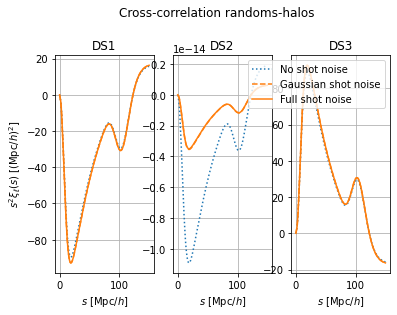

In [14]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s = model.sep

for i in range(model.nsplits):
    axes[i].plot(s, s**2 * ccf_randoms_tracers[i], label='No shot noise', ls=':', color='C0')
    axes[i].plot(s, s**2 * ccf_randoms_tracers_gaussian_shot_noise[i], label='Gaussian shot noise', ls='--', color='C1')
    axes[i].plot(s, s**2 * ccf_randoms_tracers_shot_noise[i], label='Full shot noise', ls='-', color='C1')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle('Cross-correlation randoms-halos', y=1.05)
plt.show()

In [15]:
mocks_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_10_gaussianMocksWeightedByDelta_truncatedPk_nbar0.01_densitySplit_fixedBins_rh_CCF_cellsize10_randomsize4_all.npy', allow_pickle=True)
mocks_xiell_rh, cov_rh = get_split_poles(mocks_split_results, ells=[0], nsplits=model.nsplits)
std_rh = np.array_split(np.array(np.array_split(np.diag(cov_rh)**0.5, 1)), model.nsplits, axis=1)/np.sqrt(10)

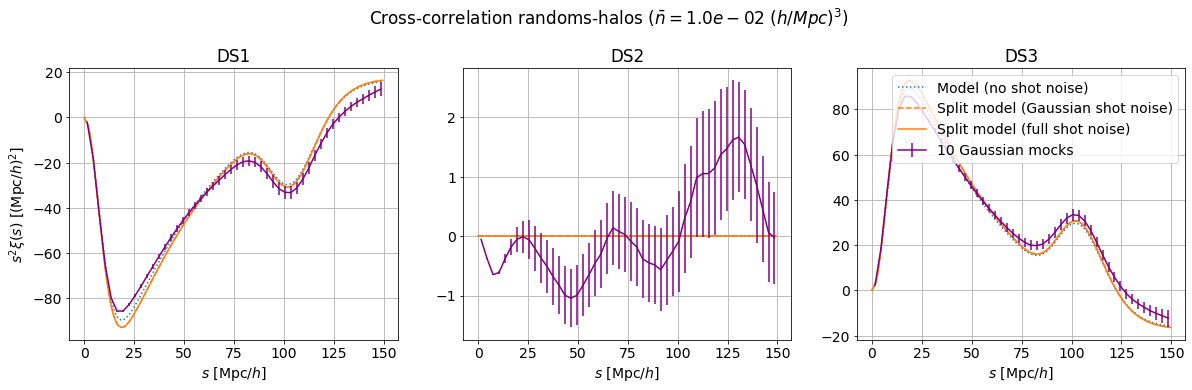

In [16]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s, _, res = mocks_split_results[0][0].get_corr(return_sep=True)
sep = model.sep

for i in range(model.nsplits):
    axes[i].plot(sep, sep**2 * ccf_randoms_tracers[i], label = 'Model (no shot noise)', ls=':', color='C0')
    #axes[i].plot(sep, sep**2 * a[i], label = r'Model ($\tilde{\delta}$ from mocks)', ls='--', color='C0')
    axes[i].plot(sep, sep**2 * ccf_randoms_tracers_gaussian_shot_noise[i], label = 'Split model (Gaussian shot noise)', ls='--', color='C1')
    axes[i].plot(sep, sep**2 * ccf_randoms_tracers_shot_noise[i], label = 'Split model (full shot noise)', ls='-', color='C1')
    #result1 = np.ravel(mocks_split_results[0][i].get_corr(ells=[0], return_sep=False))
    #axes[i].plot(s, s**2 * result1, label = 'Gaussian mock', ls='-', color='purple')
    axes[i].errorbar(s, s**2 * mocks_xiell_rh[i][0], s**2 * std_rh[i][0], label = r'10 Gaussian mocks', color='purple')# ($\bar{{n}}$ = {:.1e})'.format(nbar), color='C0')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
#axes[1].set_ylim((-20, 20))
axes[2].legend()

plt.suptitle(r'Cross-correlation randoms-halos ($\bar{{n}} = {:.1e}$ $(h/Mpc)^3)$'.format(nbar), y=1.05)
plt.show()

In [93]:
output_dir = '/feynman/work/dphp/mp270220/outputs/'

result = list()
density_bins = th_bins

for i in range(3):
    d1 = density_bins[i]
    print(d1)
    d2 = density_bins[i+1]
    print(d2)

    res = list()

    for i in range(10):

        mock_catalog = catalog_data.Data.load(output_dir+'mocks/gaussian/AbacusSummit_1Gpc_z1.175_gaussianMock{}_truncatedPk.npy'.format(i))
        mock_catalog.weights = mock_catalog.weights
        nbar = np.sum(mock_catalog.weights)/mock_catalog.boxsize**3
        nmesh = 512

        cellsize = 10
        resampler = 'tsc'

        mock_density = density_split.DensitySplit(mock_catalog)
        mock_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)

        ## Generate random particles and readout density at each particle
        rng = np.random.RandomState(seed=i)
        positions = [o + rng.uniform(0., 1., mock_density.data.size)*b for o, b in zip((mock_density.offset,)*3, (mock_density.boxsize,)*3)]
        shifted_positions = np.array(positions) - mock_density.offset
        densities = mock_density.density_mesh.readout(shifted_positions.T, resampler=resampler)

        import scipy.stats
        
        split = np.logical_and((densities > d1), (densities <= d2))
        print(np.where(split))
        split_densities = densities[split]
        print(split_densities)
        aux = np.mean(split_densities)
        res.append(aux)
        
    result.append(np.mean(np.array(res)))

-inf
-0.21870730763834242
[057951.59]  12-06 10:10  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 2934922.
[057952.77]  12-06 10:10  CatalogMesh                  INFO     Painted 2934922 out of 2934922 objects to mesh.
(array([      0,       3,       6, ..., 2934918, 2934919, 2934920]),)
[-0.88436294 -0.22963861 -0.50598389 ... -0.46486235 -0.77206328
 -0.5480572 ]
[057954.15]  12-06 10:10  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 2934922.
[057955.36]  12-06 10:10  CatalogMesh                  INFO     Painted 2934922 out of 2934922 objects to mesh.
(array([      3,       4,       6, ..., 2934916, 2934917, 2934921]),)
[-0.91107495 -1.53531179 -0.57278885 ... -0.29886568 -0.2877303
 -0.54454112]
[057956.66]  12-06 10:10  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 2934922.
[057957.49]  12-06 10:11  CatalogMesh                  INFO     Painted 2934922 out of 2934922 objects to mesh.
(array([      0,       2,       8, ..., 2934915, 2934916, 2934921

In [89]:
densities

array([ 1.15322106, -0.69391392,  0.08955361, ..., -0.47566572,
       -0.09003787,  0.76158675])

In [94]:
split_delta_tilde = np.array(result)
a = list()
for i in range(len(density_bins) - 1):
    a.append(model.xi_R / model.sigma_RR**2 * split_delta_tilde[i])
a = np.array(a)

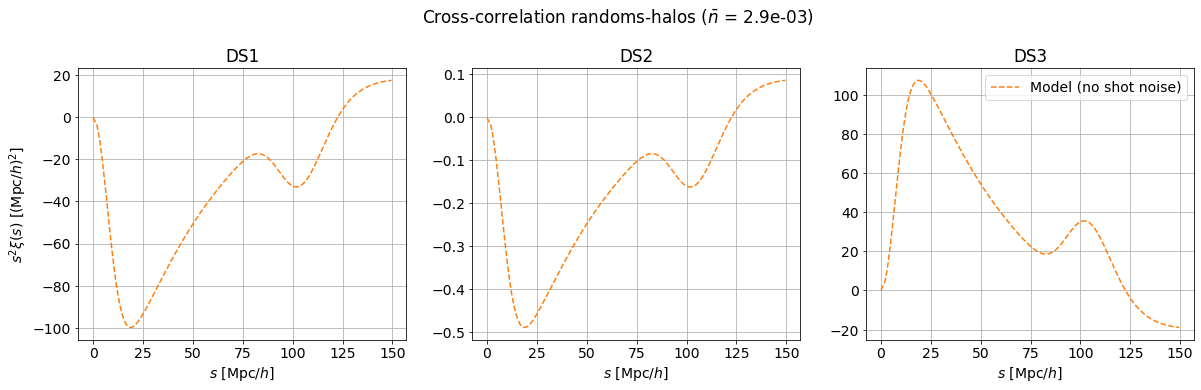

In [95]:
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s, _, res = mocks_split_results[0][0].get_corr(return_sep=True)
sep = model.sep

for i in range(model.nsplits):
    axes[i].plot(sep, sep**2 * a[i], label = 'Model (no shot noise)', ls='--', color='C1')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
#axes[1].set_ylim((-20, 20))
axes[2].legend()

plt.suptitle(r'Cross-correlation randoms-halos ($\bar{{n}}$ = {:.1e})'.format(nbar), y=1.05)
plt.show()